## 0. Install instructions

Be sure that an up-to-date version of Python3 is installed in order to build and run this package. Download the source code from: https://github.com/edejong-caltech/PySDM/tree/edj-Breakup, or install using suggested steps below.

Build the module. Be sure all requirements are install and up to date.

Tests and examples that use breakup can be found in "../PySDM_tests", including this notebook.

You can view all the contributions that I have made to this code base by comparing it to the original: https://github.com/atmos-cloud-sim-uj/PySDM

## 1. Background

PySDM is an existing superdroplet-method code that can handle many sets of particle processes, excluding breakup. The purpose of this project is to add a breakup-type process to the codebase for future research and testing. I extend the current implementation of particle coalescence to include breakup as well, with the following algorithm (my contributions and changes marked in green).

1. Randomly order the existing list of superdroplets, and generate a random number for collision probability.

2. Group the ordered list of superdroplets into pairs.

3. a) Compute the probability of a collision, based on collision kernel
      - <span style='color:green'> In the new version, coalescence and breakup take an additional argument: coalescence efficiency $E_c$. This required a minor modification to the backend and front end for "PySDM/dynamics/coalescence.py" and a new module "PySDM/physics/coalescence_efficiences.py". </span>
      - As in the literature, coalescence proceeds with rate $K(x,y)E_c$ and breakup with rate $K(x,y)(1-E_c)$ where $K(x,y)$ is the rate of collisions between particles of size $x$ and $y$.

   b) <span style='color:green'> Compute the number of fragments resulting from collisional breakup. Included are two example fragmentation functions: "PySDM/physics/breakup_fragmentations/slams.py" and ".../alwaysn.py". </span>
   
4. Compute $\gamma$, the number of collisions that lead to <span style='color:green'> breakup </span> (rather than to coalescence).

5. Perform the breakup step.
   

#### <span style='color:green'> Breakup step </span>  

The breakup step that updates particle attributes, which is called from "dynamics/breakup.py" and "state/particles.py", is based on the backend kernel for coalescence with modifications to include the fragmentation. The CPU backend source code is found in <span style='color:green'> "backends/numba/impl/_algorithmic_methods.py" </span>. The steps are as follows:

- If $\gamma = 0$, no collision; continue
- Else, for particles $j, k$ with multiplicities $n[j]$ and $n[k]$ and extrinsic attributes $a[j]$ and $a[k]$, find the new number of particles $n'[j] = n[j] - \gamma n[k]$

- If $n'[j] > 0$, update the attributes and particle counts:
    * $n[j]$ = $n'[j]$, $a[j]$ unchanged
    * $n[k]$ = $n[k] * n_{fragment}$
    * $a[k]$ = $\frac{a[k] + \gamma a[j]}{n_{fragment}}$
- Else split the resulting single droplet $a[k]$ into two superdroplets with equal attributes and half the multiplicity.

- If any SD multiplicities are zero, flag them.

## 2. Demonstration:

### a. Simple breakup only
The following demonstrates an initial droplet population in a zero-D "Box" that undergoes only breakup.

In [1]:
import sys
import numpy as np

from PySDM.backends import CPU
from PySDM.builder import Builder
from PySDM.environments import Box
from PySDM.dynamics import Breakup
from PySDM.dynamics import Coalescence
from PySDM.initialisation.spectral_sampling import ConstantMultiplicity

from PySDM.products.state import ParticlesVolumeSpectrum, ParticlesConcentration, ParticleMeanRadius
from PySDM.products.stats.timers import WallTime

from matplotlib import pyplot

from PySDM.initialisation.spectra import Exponential
from PySDM.physics.coalescence_kernels import Golovin, Geometric
from PySDM.physics.coalescence_efficiencies import Berry1967, ConstEc
from PySDM.physics.breakup_fragmentations import AlwaysN, SLAMS
from PySDM.physics.constants import si
from PySDM.physics.formulae import Formulae
from pystrict import strict

from numba import config, threading_layer
config.THREADING_LAYER = 'threadsafe'

In [2]:
@strict
class Settings:

    def __init__(self):
        self.formulae = Formulae()
        self.n_sd = 2**12
        self.n_part = 100 / si.cm**3
        self.X0 = self.formulae.trivia.volume(radius=30.531 * si.micrometres)
        self.dv = 1 * si.m**3
        self.norm_factor = self.n_part * self.dv
        self.rho = 1000 * si.kilogram / si.metre**3
        self.dt = 1 * si.seconds
        self.adaptive = False
        self.seed = 44
        self._steps = [0, 60, 120]
        self.kernel = Golovin(b=1500 / si.second)
        self.coal_eff = ConstEc(0.0)     # no collisions
        self.fragmentation = AlwaysN(n=3)
        self.spectrum = Exponential(norm_factor=self.norm_factor, scale=self.X0)
        self.radius_bins_edges = np.logspace(np.log10(10 * si.um), np.log10(100 * si.um), num=128, endpoint=True)
        self.radius_range = [0 * si.um, 1e6 * si.um]

    @property
    def output_steps(self):
        return [int(step/self.dt) for step in self._steps]

/home/edejong/.local/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


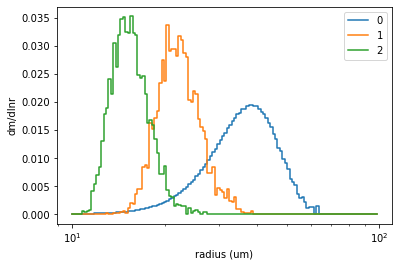

In [3]:
settings = Settings()
backend = CPU

builder = Builder(n_sd=settings.n_sd, backend=backend, formulae=settings.formulae)
builder.set_environment(Box(dv=settings.dv, dt=settings.dt))
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
breakup = Breakup(settings.kernel, settings.coal_eff, settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)
products = [ParticlesVolumeSpectrum(), WallTime(), ParticleMeanRadius(), ParticlesConcentration(radius_range = settings.radius_range)]
core = builder.build(attributes, products)

for step in settings.output_steps:
    core.run(step - core.n_steps)
    pyplot.step(x=settings.radius_bins_edges[:-1] / si.micrometres, 
                y=core.products['dv/dlnr'].get(settings.radius_bins_edges) * settings.rho,
                where='post', label="t = {step*settings.dt}s")
    #print(core.products['radius_m1'].get(), core.products['n_a_cm3'].get())
    
pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dm/dlnr")
pyplot.legend([0, 1, 2])

Notice that as time progresses, the droplet mass spectrum shifts toward smaller and smaller droplets due to fragmentation.

### b. Stochastic Fragmentation
This time we will use the stochastic SLAMS fragmentation function rather than the simple constant fragmentation number above.

In [8]:
#@strict
class Settings:

    def __init__(self):
        self.formulae = Formulae()
        self.n_sd = 2**12
        self.n_part = 100 / si.cm**3
        self.X0 = self.formulae.trivia.volume(radius=30.531 * si.micrometres)
        self.dv = 1 * si.m**3
        self.norm_factor = self.n_part * self.dv
        self.rho = 1000 * si.kilogram / si.metre**3
        self.dt = 1 * si.seconds
        self.adaptive = False
        self.seed = 44
        self._steps = [0, 30, 60]
        self.kernel = Golovin(b=1500 / si.second)
        self.coal_eff = ConstEc(0.0)     # no collisions
        self.fragmentation = SLAMS()
        self.spectrum = Exponential(norm_factor=self.norm_factor, scale=self.X0)
        self.radius_bins_edges = np.logspace(np.log10(1 * si.um), np.log10(100 * si.um), num=128, endpoint=True)
        self.radius_range = [0 * si.um, 1e6 * si.um]

    @property
    def output_steps(self):
        return [int(step/self.dt) for step in self._steps]

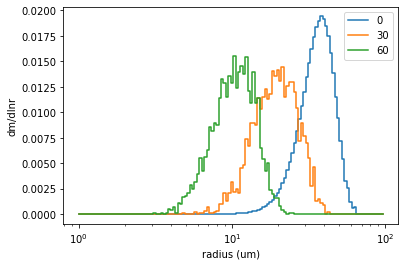

In [9]:

settings = Settings()

backend = CPU
builder = Builder(n_sd=settings.n_sd, backend=backend, formulae=settings.formulae)
builder.set_environment(Box(dv=settings.dv, dt=settings.dt))
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
breakup = Breakup(settings.kernel, settings.coal_eff, settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)
coalescence = Coalescence(settings.kernel, settings.coal_eff, adaptive=settings.adaptive)
builder.add_dynamic(coalescence)
products = [ParticlesVolumeSpectrum(), WallTime(), ParticleMeanRadius(), ParticlesConcentration(radius_range = settings.radius_range)]
core = builder.build(attributes, products)

for step in settings.output_steps:
    core.run(step - core.n_steps)
    pyplot.step(x=settings.radius_bins_edges[:-1] / si.micrometres, 
                y=core.products['dv/dlnr'].get(settings.radius_bins_edges) * settings.rho,
                where='post')#, label="t = {step*settings.dt}s")
    
pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dm/dlnr")
pyplot.legend(settings._steps)

In this example, we simulate only 1 minute rather than 2 minutes. Notice first that the breakup happens much more quickly, since particles are able to fragment into more pieces. Notice also the more jagged profile following breakup: because the number of fragments is determined stochastically as well as the collision probability, there is more noise in the product size distribution.

In reality, this SLAMS kernel is taken from a paper on phytoplankton and microphysics droplets have a tendency to fragment most often into two fragments.

### c. Collisions and Breakup: constant collection efficiency
In this example, we allow both collisions and breakup, mitigating the ratio of the two with the collision efficiency Ec. For now let's stick with the same Golovin kernel from above. Try playing with the setting of ConstEc in settings to change the relative amount of breakup/collisions.

In [6]:
#@strict
class Settings:

    def __init__(self):
        self.formulae = Formulae()
        self.n_sd = 2**12
        self.n_part = 100 / si.cm**3
        self.X0 = self.formulae.trivia.volume(radius=30.531 * si.micrometres)
        self.dv = 1 * si.m**3
        self.norm_factor = self.n_part * self.dv
        self.rho = 1000 * si.kilogram / si.metre**3
        self.dt = 1 * si.seconds
        self.adaptive = False
        self.seed = 44
        self._steps = [0, 120, 240]
        self.kernel = Golovin(b=1500 / si.second)
        self.coal_eff = ConstEc(0.4)
        self.fragmentation = AlwaysN(n=2)
        self.spectrum = Exponential(norm_factor=self.norm_factor, scale=self.X0)
        self.radius_bins_edges = np.logspace(np.log10(10 * si.um), np.log10(100 * si.um), num=128, endpoint=True)
        self.radius_range = [0 * si.um, 1e6 * si.um]

    @property
    def output_steps(self):
        return [int(step/self.dt) for step in self._steps]

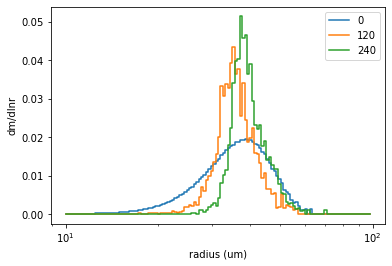

In [7]:

settings = Settings()

backend = CPU
builder = Builder(n_sd=settings.n_sd, backend=backend, formulae=settings.formulae)
builder.set_environment(Box(dv=settings.dv, dt=settings.dt))
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
breakup = Breakup(settings.kernel, settings.coal_eff, settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)
coalescence = Coalescence(settings.kernel, settings.coal_eff, adaptive=settings.adaptive)
builder.add_dynamic(coalescence)
products = [ParticlesVolumeSpectrum(), WallTime(), ParticleMeanRadius(), ParticlesConcentration(radius_range = settings.radius_range)]
core = builder.build(attributes, products)

for step in settings.output_steps:
    core.run(step - core.n_steps)
    pyplot.step(x=settings.radius_bins_edges[:-1] / si.micrometres, 
                y=core.products['dv/dlnr'].get(settings.radius_bins_edges) * settings.rho,
                where='post')#, label="t = {step*settings.dt}s")
    
pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dm/dlnr")
pyplot.legend(settings._steps)

This case is a little more nuanced: since collisions and breakup both proceed, it appears that the main mode of the distribution does not change, but the distribution narrows due to the uniform fragmentation. If you decrease Ec or increase the number of fragments to $n=3$, breakup will eventually take over.

### d. Collisions and Breakup with realistic kernel & efficiency

For this final example, let us shift to the most physically realistic "hydrodynamic" collision kernel with a collection efficiency parameterized by Berry in his 1967 work.

In [10]:
#@strict
class Settings:

    def __init__(self):
        self.formulae = Formulae()
        self.n_sd = 2**12
        self.n_part = 100 / si.cm**3
        self.X0 = self.formulae.trivia.volume(radius=30.531 * si.micrometres)
        self.dv = 1 * si.m**3
        self.norm_factor = self.n_part * self.dv
        self.rho = 1000 * si.kilogram / si.metre**3
        self.dt = 1 * si.seconds
        self.adaptive = False
        self.seed = 44
        self._steps = [0, 10, 20]
        self.kernel = Geometric()
        self.coal_eff = Berry1967()
        self.fragmentation = AlwaysN(n=2)
        self.spectrum = Exponential(norm_factor=self.norm_factor, scale=self.X0)
        self.radius_bins_edges = np.logspace(np.log10(10 * si.um), np.log10(100 * si.um), num=128, endpoint=True)
        self.radius_range = [0 * si.um, 1e6 * si.um]

    @property
    def output_steps(self):
        return [int(step/self.dt) for step in self._steps]

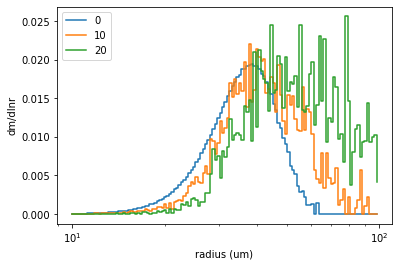

In [11]:
settings = Settings()

backend = CPU
builder = Builder(n_sd=settings.n_sd, backend=backend, formulae=settings.formulae)
builder.set_environment(Box(dv=settings.dv, dt=settings.dt))
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
breakup = Breakup(settings.kernel, settings.coal_eff, settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)
coalescence = Coalescence(settings.kernel, settings.coal_eff, adaptive=settings.adaptive)
builder.add_dynamic(coalescence)
products = [ParticlesVolumeSpectrum(), WallTime(), ParticleMeanRadius(), ParticlesConcentration(radius_range = settings.radius_range)]
core = builder.build(attributes, products)

for step in settings.output_steps:
    core.run(step - core.n_steps)
    pyplot.step(x=settings.radius_bins_edges[:-1] / si.micrometres, 
                y=core.products['dv/dlnr'].get(settings.radius_bins_edges) * settings.rho,
                where='post')
    
pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dm/dlnr")
pyplot.legend(settings._steps)

And, as a final comparison, here is the same set of dynamics, including the collection efficiency, with no breakup. It is controversial in the literature whether breakup is significant enough to include as a process for this type of simulation, but clearly in this instance in makes a difference in the dynamics.

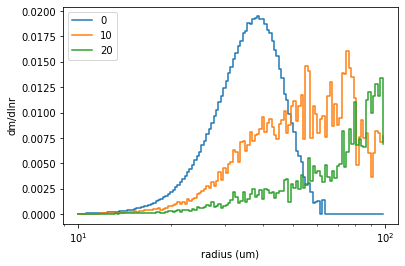

In [12]:
settings = Settings()

backend = CPU
builder = Builder(n_sd=settings.n_sd, backend=backend, formulae=settings.formulae)
builder.set_environment(Box(dv=settings.dv, dt=settings.dt))
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
#breakup = Breakup(settings.kernel, settings.coal_eff, settings.fragmentation, adaptive=settings.adaptive)
#builder.add_dynamic(breakup)
coalescence = Coalescence(settings.kernel, settings.coal_eff, adaptive=settings.adaptive)
builder.add_dynamic(coalescence)
products = [ParticlesVolumeSpectrum(), WallTime(), ParticleMeanRadius(), ParticlesConcentration(radius_range = settings.radius_range)]
core = builder.build(attributes, products)

for step in settings.output_steps:
    core.run(step - core.n_steps)
    pyplot.step(x=settings.radius_bins_edges[:-1] / si.micrometres, 
                y=core.products['dv/dlnr'].get(settings.radius_bins_edges) * settings.rho,
                where='post')
    
pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dm/dlnr")
pyplot.legend(settings._steps)